In [1]:
import numpy as np 
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

<Axes: >

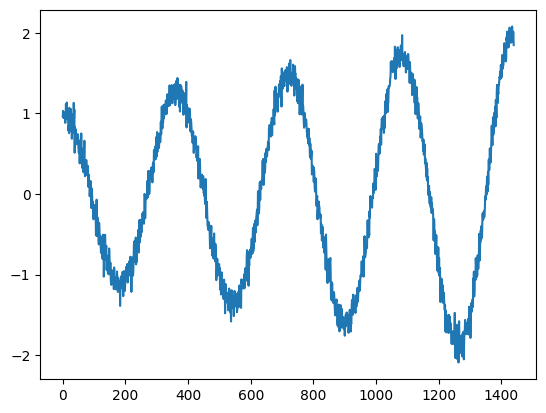

In [2]:
num_points = 360*4
X = np.arange(num_points)
y = [np.cos(X[i]*np.pi/180) * (1+i/num_points) + (np.random.randn(1)*0.1)[0] for i in range(len(X))]
sns.lineplot(x=X, y=y)

In [3]:
X_restruct = [] 
y_restruct = [] 

for i in range(num_points-10):
     list1 = []
     for j in range(i,i+10):
         list1.append(y[j])
     X_restruct.append(list1)
     y_restruct.append(y[j+1])
X_restruct = np.array(X_restruct)
y_restruct = np.array(y_restruct)

In [4]:
train_test_clipping = 360*3
X_train = X_restruct[:train_test_clipping]
X_test = X_restruct[train_test_clipping:]
y_train = y_restruct[:train_test_clipping]
y_test = y_restruct[train_test_clipping:]

In [5]:
class TrigonometricDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [6]:
train_loader = DataLoader(TrigonometricDataset(X_train, y_train), batch_size=2)
test_loader = DataLoader(TrigonometricDataset(X_test, y_test), batch_size=len(y_test))


<Axes: >

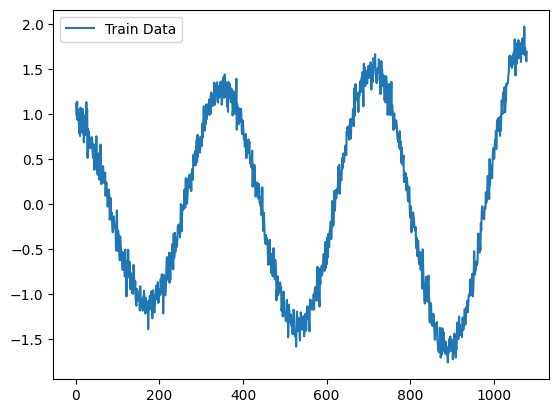

In [7]:
sns.lineplot(x=range(len(y_train)), y=y_train, label = 'Train Data')

In [14]:
# %% Model
class TrigonometryModel(nn.Module):
    def __init__(self, input_size=1, output_size=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x, status = self.lstm(x)
        x = x[:, -1, :]  # reshape for fc layer; out: BS, hidden
        x = self.fc1(x)
        x = self.relu(x)

        return x

In [15]:
model = TrigonometryModel()
input = torch.rand((2, 10, 1))  # BS, seq_len, input_size
model(input).shape  # out: [BS, seq_len, hidden]

torch.Size([2, 1])

In [16]:
loss_fun = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
NUM_EPOCHS = 20

In [ ]:
# %% Train
for epoch in range(NUM_EPOCHS):
    for j, (X, y) in enumerate(train_loader):
        optimizer.zero_grad()
        y_pred = model(X.view(-1, 10, 1))
        loss = loss_fun(y_pred, y.unsqueeze(1))
        loss.backward()
        optimizer.step()
    print(f"Epoch: {epoch}, Loss: {loss.data}")

In [ ]:
test_set = TrigonometricDataset(X_test, y_test)
X_test_torch, y_test_torch = next(iter(test_loader))
with torch.no_grad():
    y_pred = model(torch.unsqueeze(X_test_torch, 2)).detach().squeeze().numpy()
y_act = y_test_torch.numpy()
x_act = range(y_act.shape[0])
sns.lineplot(x=x_act, y=y_act, label="Actual", color="black")
sns.lineplot(x=x_act, y=y_pred, label="Predicted", color="red")

In [ ]:
sns.scatterplot(x=y_act, y=y_pred, label="Predicted", color="red", alpha=0.5)